In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

import bincounts
import srmse

In [5]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','PWGTP','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)
pums_data['PINCP'], pincp_bins = pd.qcut(pums_data['PINCP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

# Scale by the person-weights to get true population
pums_data = pums_data.reindex(pums_data.index.repeat(pums_data['PWGTP']))
pums_data = pums_data.drop('PWGTP', axis=1)
pums_data_p = pums_data_p.drop('PWGTP', axis=1)
pums_data = pums_data.sample(150000)
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
136262,6.0,5,8.0,2,16.0,1,1.0,2.0,2,2.0,1,5.0,2,2.0,2.0,1.0
219830,5.0,6,5.0,2,21.0,1,3.0,2.0,2,2.0,1,6.0,3,4.0,2.0,1.0
122627,9.0,7,6.0,1,21.0,1,7.0,2.0,2,2.0,1,8.0,2,4.0,2.0,1.0
285596,9.0,6,8.0,1,21.0,1,1.0,2.0,2,2.0,1,9.0,3,2.0,2.0,1.0
162482,2.0,3,4.0,1,17.0,1,1.0,2.0,2,2.0,1,1.0,5,2.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212372,9.0,4,6.0,2,21.0,1,1.0,2.0,2,2.0,1,9.0,3,3.0,2.0,1.0
14275,6.0,4,4.0,1,14.0,1,1.0,2.0,2,2.0,1,3.0,3,3.0,2.0,1.0
289123,8.0,4,7.0,2,21.0,1,2.0,2.0,2,2.0,1,8.0,3,4.0,2.0,1.0
233239,1.0,6,6.0,2,16.0,1,1.0,2.0,2,2.0,1,4.0,6,3.0,2.0,1.0


In [6]:
popsim_data_p = pd.read_csv('./populationsim-master/example_wa_16/output/synthetic_persons.csv')[['household_id','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']].dropna()
popsim_data_h = pd.read_csv('./populationsim-master/example_wa_16/output/synthetic_households.csv')[['household_id','HINCP','NP','VEH','BLD','ACCESS']].dropna()
popsim_data = pd.merge(popsim_data_p,popsim_data_h, on='household_id')
popsim_data = popsim_data.drop(labels='household_id', axis=1)

# Convert numerical variables to categorical bins
popsim_data['HINCP'] = pd.cut(popsim_data['HINCP'], bins=hincp_bins, labels=False)
popsim_data['AGEP'] = pd.cut(popsim_data['AGEP'], bins=agep_bins, labels=False)
popsim_data['JWMNP'] = pd.cut(popsim_data['JWMNP'], bins=jwmnp_bins, labels=False)
popsim_data['PINCP'] = pd.cut(popsim_data['PINCP'], bins=pincp_bins, labels=False)

# Remove NA values and check n before/after
print(f"Dataset n={len(popsim_data)} pre-cleaning")
popsim_data = popsim_data.dropna()
print(f"Dataset n={len(popsim_data)} post-cleaning")
popsim_data

Dataset n=3257534 pre-cleaning
Dataset n=3228874 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,9,5,1.0,1,16.0,1,1.0,2.0,2,2.0,1,9,5,3.0,2.0,1.0
1,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
2,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
3,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
4,9,9,0.0,1,22.0,1,7.0,2.0,2,2.0,1,9,3,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257529,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257530,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257531,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0
3257532,2,3,9.0,2,21.0,5,3.0,2.0,2,2.0,1,0,1,0.0,9.0,1.0


In [7]:
popsim_data_h

,household_id,HINCP,NP,VEH,BLD,ACCESS
0,1,249400.0,5,3.0,2.0,1.0
1,2,369000.0,3,3.0,2.0,1.0
2,3,369000.0,3,3.0,2.0,1.0
3,4,369000.0,3,3.0,2.0,1.0
4,5,369000.0,3,3.0,2.0,1.0
...,...,...,...,...,...,...
2848391,2848392,8000.0,1,0.0,9.0,1.0
2848392,2848393,8000.0,1,0.0,9.0,1.0
2848393,2848394,8000.0,1,0.0,9.0,1.0
2848394,2848395,8000.0,1,0.0,9.0,1.0


In [8]:
popsim_data_p

,household_id,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P
0,1,124700.0,42,10.0,1,16.0,1,1.0,2.0,2,2.0,1
1,2,301000.0,76,5.0,1,22.0,1,7.0,2.0,2,2.0,1
2,3,301000.0,76,5.0,1,22.0,1,7.0,2.0,2,2.0,1
3,4,301000.0,76,5.0,1,22.0,1,7.0,2.0,2,2.0,1
4,5,301000.0,76,5.0,1,22.0,1,7.0,2.0,2,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3257529,2848392,8000.0,29,90.0,2,21.0,5,3.0,2.0,2,2.0,1
3257530,2848393,8000.0,29,90.0,2,21.0,5,3.0,2.0,2,2.0,1
3257531,2848394,8000.0,29,90.0,2,21.0,5,3.0,2.0,2,2.0,1
3257532,2848395,8000.0,29,90.0,2,21.0,5,3.0,2.0,2,2.0,1


In [9]:
vae_data = pd.read_csv('./data/synthetic_populations/wa_persons_100000.csv')[['PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P','HINCP','NP','VEH','BLD','ACCESS']].dropna()
vae_data

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,7.0,8,4.0,1,22.0,5,3.0,2.0,2,2.0,1,3.0,1,1.0,2.0,1.0
1,1.0,3,8.0,1,16.0,3,1.0,2.0,2,2.0,1,0.0,2,2.0,2.0,1.0
2,1.0,2,1.0,2,16.0,5,1.0,2.0,2,2.0,1,0.0,2,2.0,2.0,1.0
3,5.0,8,5.0,2,24.0,1,5.0,2.0,2,2.0,6,7.0,2,3.0,2.0,1.0
4,7.0,5,0.0,2,19.0,5,1.0,2.0,2,2.0,1,7.0,2,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268700,9.0,7,4.0,1,16.0,1,2.0,2.0,2,2.0,1,8.0,2,0.0,7.0,1.0
268701,7.0,8,1.0,2,24.0,3,5.0,2.0,2,2.0,6,8.0,2,0.0,7.0,1.0
268702,3.0,6,1.0,2,24.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0
268703,5.0,8,1.0,2,22.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0


In [10]:
# Time Tests
num_variables = [4,8,16]
time_vae_train_hh = [51,57,63]
time_vae_gen_hh = [52,48,54]
time_vae_train_p = [134,95,120]
time_vae_gen_p = [129,210,449]
time_vae = []
for i in range(len(num_variables)):
    z = time_vae_train_hh[i]+time_vae_gen_hh[i]+time_vae_train_p[i]+time_vae_gen_p[i]
    time_vae.append(z)
time_pop = [245,588,924]
time_vae

[366, 410, 686]

In [11]:
print((924-686)/(924)) # pct improvement

0.25757575757575757


### SRMSE Accuracy Tests

In [12]:
# # SRMSE for the recreated popsim data
print("POPSIM")
srmse_uni_pop = srmse.calculateSRMSE(popsim_data.sample(len(pums_data), replace=True), pums_data)
srmse_bi_pop = srmse.calculateBivariateSRMSE(popsim_data.sample(len(pums_data), replace=True), pums_data)

POPSIM
Univariate (marginal) SRMSE: 0.3174000795651855, Total Bins: 131
Bivariate (joint) SRMSE: 0.8629188468080834, Total Bins: 7768


In [13]:
# # SRMSE for the recreated cvae data
print("CVAE")
srmse_uni_cvae = srmse.calculateSRMSE(vae_data.sample(len(pums_data), replace=True), pums_data)
srmse_bi_cvae = srmse.calculateBivariateSRMSE(vae_data.sample(len(pums_data), replace=True), pums_data)

CVAE
Univariate (marginal) SRMSE: 0.29492725002261616, Total Bins: 131
Bivariate (joint) SRMSE: 0.8422304884059021, Total Bins: 7768


In [14]:
print((srmse_uni_pop-srmse_uni_cvae)/(srmse_uni_pop)*100) # pct difference
print((srmse_bi_pop-srmse_bi_cvae)/(srmse_bi_pop)*100) # pct difference

7.080284785484444
2.397485983613298


### SRMSE Sparse Data Test Results

In [15]:
# Data Tests for VAE
num_samples = [100000,10000,1000,100,10,1]
srmse_uni_vae = [.0379,.0341,.0442,.0555,.1289,.2314]
srmse_bi_vae = [.0061,.0058,.0091,.0111,.0200,.0351]

In [16]:
# Reset the index in PUMS data because it was duplicated when weighting
pums_data.reset_index(inplace=True)

In [17]:
all_pops = []
for num in num_samples:
    pop = pd.read_csv(f"./data/synthetic_populations/wa_persons_{num}.csv")
    pop['num_samples'] = num
    all_pops.append(pop)
all_pops = pd.concat(all_pops)

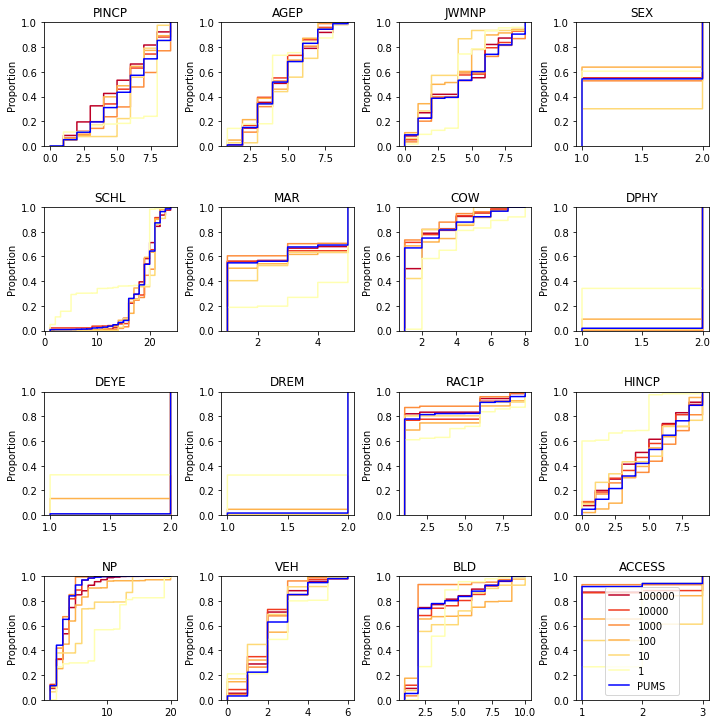

In [18]:
colors = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
colors.reverse()

# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.tight_layout(h_pad=4)

# Plot distribution of each variable for each number of population sample size
for j, popsize in enumerate(num_samples):
    data_subset = all_pops[all_pops['num_samples']==popsize]
    for i, var in enumerate(data_subset.columns[:-1]):
        sns.ecdfplot(data=data_subset, x=var, color=colors[j], ax=axes.flatten()[i])
        axes.flatten()[i].set_title(var)
        axes.flatten()[i].set_xlabel(None)

# Plot the PUMS data distribution on top
for i, var in enumerate(data_subset.columns[:-1]):
    sns.ecdfplot(data=pums_data, x=var, color='blue', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(var)
    axes.flatten()[i].set_xlabel(None)

# Add legend with label for PUMS
plt.legend(labels=num_samples+['PUMS'])

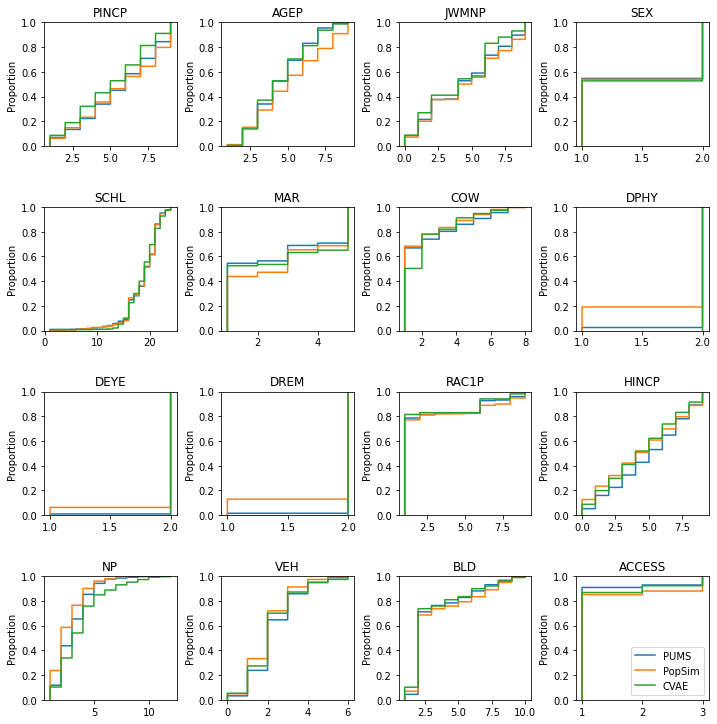

In [19]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(vae_data.columns):
    sns.ecdfplot(data=pums_data.sample(1000), x=var, ax=axes.flatten()[i])
    sns.ecdfplot(data=popsim_data.sample(1000), x=var, ax=axes.flatten()[i])
    sns.ecdfplot(data=vae_data.sample(1000), x=var, ax=axes.flatten()[i])
    axes.flatten()[i].set_title(var)
    axes.flatten()[i].set_xlabel(None)
    plt.legend(labels=['PUMS','PopSim','CVAE'])

### Determine Statistical Significance Between Outputs

In [107]:
PINCP_bins = [i for i in range(0,11)]
AGEP_bins = [i for i in range(1,11)]
JWMNP_bins = [i for i in range(0,11)]
SEX_bins = [i for i in range(1,4)]
SCHL_bins = [i for i in range(1,26)]
MAR_bins = [i for i in range(1,7)]
COW_bins = [i for i in range(1,10)]
DPHY_bins = [i for i in range(1,4)]
DEYE_bins = [i for i in range(1,4)]
DREM_bins = [i for i in range(1,4)]
RAC1P_bins = [i for i in range(1,11)]
HINCP_bins = [i for i in range(0,11)]
NP_bins = [i for i in range(1,22)]
VEH_bins = [i for i in range(0,8)]
BLD_bins = [i for i in range(1,12)]
ACCESS_bins = [i for i in range(1,5)]
bin_list = [PINCP_bins,AGEP_bins,JWMNP_bins,SEX_bins,SCHL_bins,MAR_bins,COW_bins,DPHY_bins,
           DEYE_bins,DREM_bins,RAC1P_bins,HINCP_bins,NP_bins,VEH_bins,BLD_bins,
           ACCESS_bins]

In [151]:
# Determine whether the generated variable distributions are statistically different
# from the weighted PUMS distribution
# Reload datasets first

chi_values_popsim = []
p_values_popsim = []
chi_values_vae = []
p_values_vae = []

# Sample is set to 150k when loading PUMS
sample_size = 150000

# Add 1 to each bin, chi-sq doesn't handle zeros in both obs/exp well

print("POPSIM")
for i,var in enumerate(vae_data.columns):
    f_exp = [x+1 for x in bincounts.get_bin_counts(pums_data[var],bin_list[i])]
    f_obs = [x+1 for x in bincounts.get_bin_counts(popsim_data[var].sample(sample_size),bin_list[i])]
    result = scipy.stats.chisquare(f_exp=f_exp, f_obs=f_obs)
    chi_values_popsim.append(int(result[0]))
    p_values_popsim.append(result[1])
print(chi_values_popsim)
    
print("VAE")
for i,var in enumerate(vae_data.columns):
    f_exp = [x+1 for x in bincounts.get_bin_counts(pums_data[var],bin_list[i])]
    f_obs = [x+1 for x in bincounts.get_bin_counts(vae_data[var].sample(sample_size),bin_list[i])]
    result = scipy.stats.chisquare(f_exp=f_exp, f_obs=f_obs)
    chi_values_vae.append(int(result[0]))
    p_values_vae.append(result[1])
print(chi_values_vae)

POPSIM
[7652, 124744, 3725, 385, 2018, 16840, 2650, 206884, 36724, 124824, 1207, 29326, 34545, 16177, 3669, 10829]
VAE
[21460, 5022, 32209, 43, 31249, 731, 94168, 2908, 1684, 2665, 7775, 10734, 59760, 6988, 17868, 9023]


In [161]:
print(np.mean(chi_values_vae))

19017.9375


In [153]:
print(p_values_popsim)
print(p_values_vae)

[0.0, 0.0, 0.0, 6.485124796579703e-86, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.198847924183287e-255, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 4.464112024255862e-11, 0.0, 6.066056919647099e-157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [159]:
diffs = []
for i,val in enumerate(chi_values_vae):
    diffs.append(val-chi_values_popsim[i])
print(diffs)
print(np.mean(diffs))

[13808, -119722, 28484, -342, 29231, -16109, 91518, -203976, -35040, -122159, 6568, -18592, 25215, -9189, 14199, -1806]
-19869.5


### Compare households from CVAE and VAE

In [57]:
vae_data

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
0,7.0,8,4.0,1,22.0,5,3.0,2.0,2,2.0,1,3.0,1,1.0,2.0,1.0
1,1.0,3,8.0,1,16.0,3,1.0,2.0,2,2.0,1,0.0,2,2.0,2.0,1.0
2,1.0,2,1.0,2,16.0,5,1.0,2.0,2,2.0,1,0.0,2,2.0,2.0,1.0
3,5.0,8,5.0,2,24.0,1,5.0,2.0,2,2.0,6,7.0,2,3.0,2.0,1.0
4,7.0,5,0.0,2,19.0,5,1.0,2.0,2,2.0,1,7.0,2,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268700,9.0,7,4.0,1,16.0,1,2.0,2.0,2,2.0,1,8.0,2,0.0,7.0,1.0
268701,7.0,8,1.0,2,24.0,3,5.0,2.0,2,2.0,6,8.0,2,0.0,7.0,1.0
268702,3.0,6,1.0,2,24.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0
268703,5.0,8,1.0,2,22.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0


In [58]:
def getBin(val, var):
    switcher = {
        'HINCP': f"{hincp_bins[int(val)-1]} - {hincp_bins[int(val)]}",
        'AGEP': f"{agep_bins[int(val)-1]} - {agep_bins[int(val)]}",
        'JWMNP': f"{jwmnp_bins[int(val)-1]} - {jwmnp_bins[int(val)]}",
        'PINCP': f"{pincp_bins[int(val)-1]} - {pincp_bins[int(val)]}"
    }
    return switcher.get(var, "invalid")

In [59]:
vae_data['HINCP_val'] = vae_data['HINCP'].apply(getBin, args=('HINCP',))
vae_data['AGEP_val'] = vae_data['AGEP'].apply(getBin, args=('AGEP',))
vae_data['JWMNP_val'] = vae_data['JWMNP'].apply(getBin, args=('JWMNP',))
vae_data['PINCP_val'] = vae_data['PINCP'].apply(getBin, args=('PINCP',))

In [60]:
vae_data[vae_data['NP']==3].iloc[55660:,:]

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS,HINCP_val,AGEP_val,JWMNP_val,PINCP_val
268679,7.0,3,1.0,2,19.0,5,1.0,2.0,2,2.0,1,8.0,3,5.0,2.0,1.0,112000.0 - 139800.0,17.0 - 25.0,1.0 - 6.0,35800.0 - 48000.0
268680,8.0,8,4.0,1,16.0,1,2.0,2.0,2,2.0,1,8.0,3,5.0,2.0,1.0,112000.0 - 139800.0,56.0 - 63.0,15.0 - 18.0,48000.0 - 64800.0
268691,3.0,2,0.0,2,16.0,5,1.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,8.0 - 17.0,150.0 - 1.0,5000.0 - 11110.0
268692,3.0,4,2.0,2,16.0,1,1.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,25.0 - 33.0,6.0 - 10.0,5000.0 - 11110.0
268693,3.0,2,1.0,2,22.0,1,4.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,8.0 - 17.0,1.0 - 6.0,5000.0 - 11110.0
268702,3.0,6,1.0,2,24.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,41.0 - 49.0,1.0 - 6.0,5000.0 - 11110.0
268703,5.0,8,1.0,2,22.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,56.0 - 63.0,1.0 - 6.0,18000.0 - 26000.0
268704,2.0,3,6.0,1,19.0,5,1.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,17.0 - 25.0,20.0 - 25.0,0.0 - 5000.0


In [61]:
non_cvae_data = pd.read_csv("data/synthetic_populations/wa_persons_100000_vae.csv")
non_cvae_data['HINCP_val'] = non_cvae_data['HINCP'].apply(getBin, args=('HINCP',))
non_cvae_data['AGEP_val'] = non_cvae_data['AGEP'].apply(getBin, args=('AGEP',))
non_cvae_data['JWMNP_val'] = non_cvae_data['JWMNP'].apply(getBin, args=('JWMNP',))
non_cvae_data['PINCP_val'] = non_cvae_data['PINCP'].apply(getBin, args=('PINCP',))

In [62]:
vae_data[vae_data['NP']==3]

,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS,HINCP_val,AGEP_val,JWMNP_val,PINCP_val
24,5.0,5,6.0,1,21.0,1,2.0,2.0,2,2.0,1,1.0,3,2.0,2.0,1.0,-10200.0 - 21500.0,33.0 - 41.0,20.0 - 25.0,18000.0 - 26000.0
25,1.0,4,7.0,1,19.0,1,1.0,2.0,2,2.0,1,1.0,3,2.0,2.0,1.0,-10200.0 - 21500.0,25.0 - 33.0,25.0 - 30.0,-10500.0 - 0.0
26,3.0,5,4.0,1,21.0,1,2.0,2.0,2,2.0,6,1.0,3,2.0,2.0,1.0,-10200.0 - 21500.0,33.0 - 41.0,15.0 - 18.0,5000.0 - 11110.0
33,5.0,3,0.0,2,16.0,1,6.0,2.0,2,2.0,1,4.0,3,2.0,7.0,3.0,49000.0 - 62000.0,17.0 - 25.0,150.0 - 1.0,18000.0 - 26000.0
34,3.0,4,7.0,1,20.0,1,1.0,2.0,2,2.0,1,4.0,3,2.0,7.0,3.0,49000.0 - 62000.0,25.0 - 33.0,25.0 - 30.0,5000.0 - 11110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268692,3.0,4,2.0,2,16.0,1,1.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,25.0 - 33.0,6.0 - 10.0,5000.0 - 11110.0
268693,3.0,2,1.0,2,22.0,1,4.0,2.0,2,2.0,1,1.0,3,2.0,1.0,1.0,-10200.0 - 21500.0,8.0 - 17.0,1.0 - 6.0,5000.0 - 11110.0
268702,3.0,6,1.0,2,24.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,41.0 - 49.0,1.0 - 6.0,5000.0 - 11110.0
268703,5.0,8,1.0,2,22.0,1,4.0,2.0,2,2.0,1,4.0,3,1.0,6.0,1.0,49000.0 - 62000.0,56.0 - 63.0,1.0 - 6.0,18000.0 - 26000.0
